In [280]:
import pickle
import pandas as pd

# 데이터 읽어오기
df = pd.read_pickle('path_df.pkl')
exploit=df
exploit

,EID,PATH_NUM,SYSCALL_PATH
0,10613,exit_code,"[102, 1]"
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
2,10613,exit_code,"[102, 1]"
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]"
...,...,...,...
4076,9545,main,"[102, 104, 9, 41]"
4077,9545,main,"[102, 104, 9, 41, 87, 77, 40, 59]"
4078,9545,main,"[102, 104, 9]"
4079,9575,main,"[41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1..."


In [279]:
new_exploit_df = pd.DataFrame(columns=['EID','PATH_NUM','SYSCALL_PATH'])
split_path = list()
for one in exploit.loc:
    if not "".join(one.SYSCALL_PATH).isdigit(): #문자 포함된 SYS_PATH는 문자 기준으로 쪼개기
        for syscall in one.SYSCALL_PATH:
            if syscall.isdigit():
                split_path.append(syscall)
            else:
                if len(split_path) > 0:
                    new_exploit_df = new_exploit_df.append({'EID':one.EID, 'PATH_NUM':one.PATH_NUM, 'SYSCALL_PATH':split_path}, ignore_index=True)
                    split_path = []
            
    else:
        new_exploit_df = new_exploit_df.append(one, ignore_index=True)

KeyError: 4081

In [281]:
# syscall path만 뽑아서 이차원 데이터로 만들기
tokened_syscall_path = [syscall for syscall in df['SYSCALL_PATH']]
tokened_syscall_path[:10]

[['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22']]

In [283]:
dictionary = set()
not_syscall = set()
all =set()
for path in tokened_syscall_path:
    for syscall in path:
        all.add(syscall)
        if str.isdigit(syscall):
            dictionary.add(syscall)
        else:
            if "setns" == syscall:
                dictionary.add("setns")
            if "time" == syscall:
                dictionary.add("time")
            if "capset" == syscall:
                dictionary.add("capset")
            if "fstat" == syscall:
                dictionary.add("fstat")
            if "__NR_vm86old" == syscall:
                dictionary.add("__NR_vm86old")
            else:
                not_syscall.add(syscall)
        
print(len(dictionary))
print(len(all))

137
317


### Word2Vec의 평균을 사용한 Syscall Sequence Embedding
파라미터 의미 참고: https://hoonzi-text.tistory.com/2

In [284]:
# 모든 path 시퀀스 Word2Vec 훈련시키기
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokened_syscall_path, size=4, window=2, min_count=1, iter=100, sg=1)

In [285]:
import numpy as np
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
        else:
            document_embedding_list.append(np.zeros(100))

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

In [286]:
exploit_embedding_list = get_exploit_vectors(exploit['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_embedding_list))

/tmp/ipykernel_2159822/2519065890.py:15: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2159822/2519065890.py:17: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 4081


### Cluster 개수 결정

In [289]:

from sklearn.cluster import KMeans as km
inertia = []    # cluster 응집도
for k in range(1,31):    # 50개까지
    km_model = km(n_clusters = k, init='k-means++')
    km_model.fit(exploit_embedding_list)
    inertia.append(km_model.inertia_)

<Figure size 640x440 with 0 Axes>

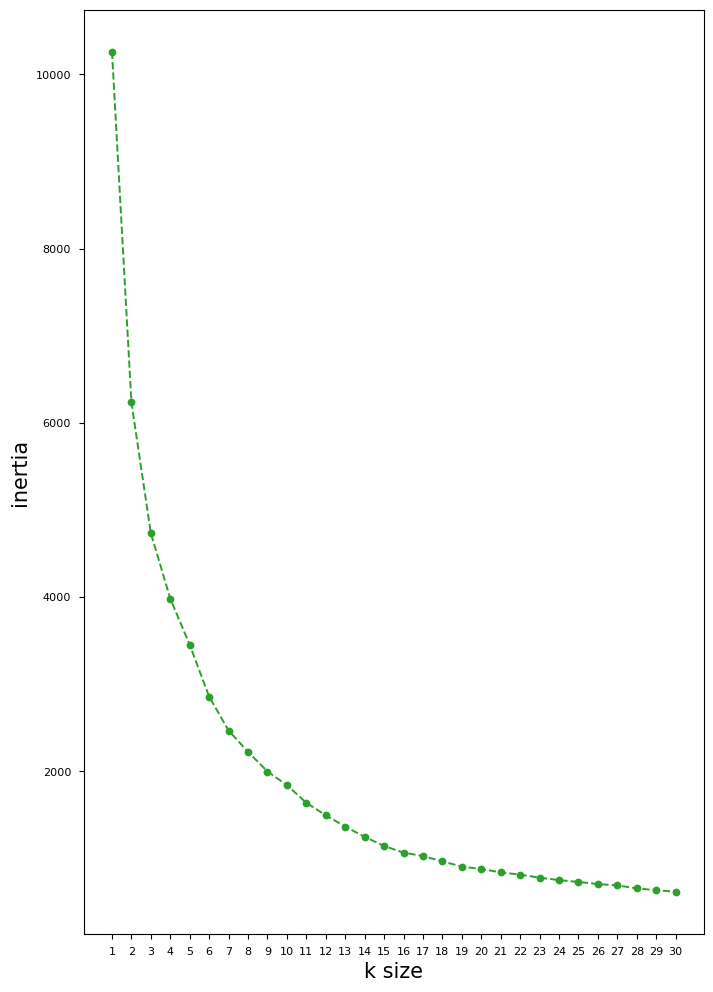

In [288]:
# 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.clf()
plt.style.use('default')
plt.style.use('seaborn-paper')

xpos = np.array(range(1,31))
fig = plt.figure(figsize=(8, 12))
plt.plot(xpos, inertia, marker='o', linestyle='--', color='#2ca02c')
plt.xlabel("k size", fontsize=15)
plt.xticks(xpos, xpos)
plt.ylabel("inertia", fontsize=15)
plt.show()

In [294]:
def unsupervised_learning(data, n): # n = k 수
    # cluster 개수 -> km_model.inertia_ 를 보면 기울기 변화가 적어지는 부분이 20
    km_model = km(n_clusters = n, algorithm = 'full', init='k-means++')
    km_model.fit(data)    # 학습
    predict_list = km_model.predict(data)    # clustering
    return predict_list

In [295]:
km_label = unsupervised_learning(exploit_embedding_list,16)
exploit['km_label'] = km_label
exploit

,EID,PATH_NUM,SYSCALL_PATH,km_label
0,10613,exit_code,"[102, 1]",2
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]",7
2,10613,exit_code,"[102, 1]",2
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]",7
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]",7
...,...,...,...,...
4076,9545,main,"[102, 104, 9, 41]",7
4077,9545,main,"[102, 104, 9, 41, 87, 77, 40, 59]",7
4078,9545,main,"[102, 104, 9]",7
4079,9575,main,"[41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...",7


Text(0.5, 1.0, 'PCA Transformed')

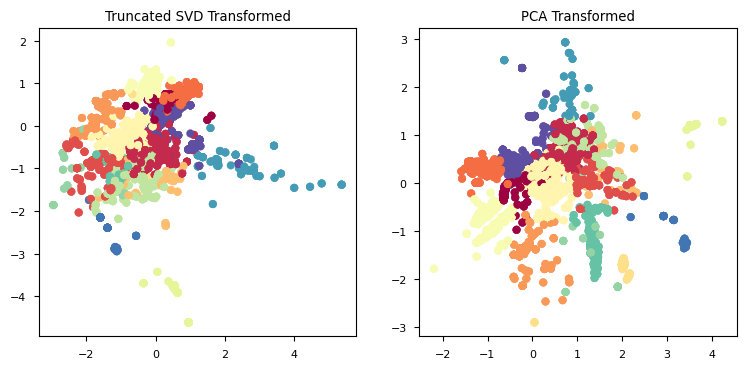

In [296]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA


# 특이값 분해
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(exploit_embedding_list)
scaler = StandardScaler() # exploit 데이터를 StandardScaler로 변환
exploit_tsvd = scaler.fit_transform(exploit_embedding_list)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(exploit_embedding_list)
exploit_pca = pca.transform(exploit_embedding_list)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=exploit_tsvd[:,0], y= exploit_tsvd[:,1], c= exploit.km_label, cmap='Spectral')
ax2.scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= exploit.km_label, cmap='Spectral')
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [297]:
pca = PCA(n_components=3)
components = pca.fit_transform(exploit_embedding_list)

total_var = pca.explained_variance_ratio_.sum() * 100
import plotly.express as px
fig = px.colors.qualitative.swatches()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=exploit.km_label,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.show()

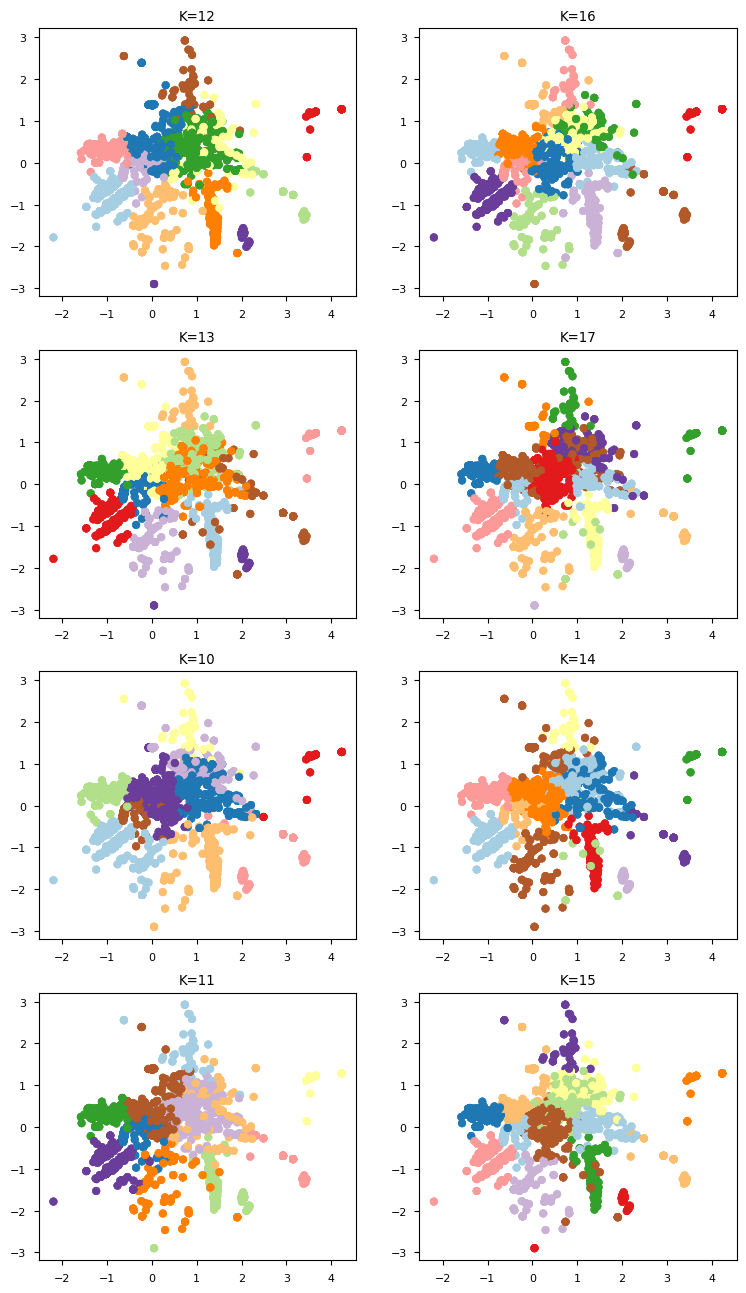

In [298]:
fig, ax = plt.subplots(figsize=(9,16), nrows=4, ncols=2)
j=0
START = 10
for i in range(START,START+8):
    km_label = unsupervised_learning(exploit_embedding_list,i)
    # TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
    ax[i%4][j].scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= km_label, cmap='Paired')
    ax[i%4][j].set_title(f'K={i}')
    if i == START+3:
        j = 1

# 같은 그룹 끼리 Cosine 유사도 비교

In [299]:
k_label = len(set(exploit.km_label))
print("K-Mean++ label 수: ", len(set(exploit.km_label)))

K-Mean++ label 수:  16


In [300]:
same_cluster_exploit = set()
cluster_exploits = list()
for label in range(k_label):
    for idx in exploit[exploit['km_label'] == label].index:
        same_cluster_exploit.add(exploit.loc[idx].EID)
    cluster_exploits.append(same_cluster_exploit.copy())
    same_cluster_exploit = set()

In [301]:
# 익스플로잇 기준 속한 그룹
all_exploits = list(set(exploit['EID']))
for eid in all_exploits:
    print(eid, set(exploit[exploit['EID'] == eid]['km_label'].values)-{0})

45553 {1, 2, 3, 4, 7, 8, 12, 14}
24746 {4, 14, 7}
43418 {2, 3, 4, 7, 15}
40049 {2, 3, 7, 8, 14}
19419 {1, 10}
37292 {1, 5}
718 {1, 10}
44300 {2, 3, 7, 8, 14}
9479 {7}
34923 {1, 2, 5, 13, 15}
42887 {3, 11, 7}
15944 {12, 14, 15}
37167 {3, 15}
41995 {2, 14}
39166 {1, 5}
9575 {7}
31574 {1}
38390 {1, 10, 5, 7}
35161 {1, 2, 7, 10, 13, 15}
3 {1, 7, 8, 10, 13}
25444 {2, 10, 7}
50135 {2, 4, 12, 14, 15}
6851 {15}
20721 {10, 13}
25450 {1, 15}
33589 {2, 14, 7}
40616 {5, 15}
15023 {1, 2, 3, 14}
44299 {2, 4, 14, 7}
45010 {9, 2, 14, 1}
44298 {1, 2, 5, 9, 14}
33824 {1, 10, 7}
14814 {2, 3, 14, 15}
47163 {2, 7, 10, 13, 15}
40812 {1, 2, 15, 7}
31347 {1, 14, 7}
20979 {2, 3, 15}
32751 {1}
33322 {1, 10, 15}
15916 {3, 12, 14}
33523 {1}
2006 {1}
20000 {1, 2, 15}
40871 {1, 4, 5, 6, 7, 10, 13}
50808 {1, 3, 15}
35370 {1, 2, 3, 4, 7, 8, 13}
4756 {1, 7}
37722 {2, 3}
39277 {5, 14, 7}
10613 {2, 7}
41886 {4}
27297 {7}
47168 {1, 2, 3, 4, 7, 15}
2004 {1, 5}
4460 {1, 2, 7}
34134 {1, 13}
39230 {1, 10}
43029 {1, 2, 3, 5, 

In [ ]:
# 클러스터 간의 핵심 단어 추출
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['label']==cluster_num]['EID']
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['EID'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['EID'][:5]}")
        print('-'*20)

cluster_details = get_cluster_details(cluster_model=km_model,
                                     cluster_data=exploit_embedding_list,
                                     feature_names=feature_names,
                                     cluster_num=len(k_label),
                                     top_n_features=10)
print_cluster_details(cluster_details)

In [303]:
# 그룹 기준 속한 익스플로잇 
all_exploits = list(set(exploit['EID']))
cluster_exploits = list()
for label in range(k_label):
    cluster_exploits.append(list(set(exploit[exploit['km_label'] == label]['EID'])))
for cluster in cluster_exploits:
    print(cluster)

['40616', '45553', '24746', '43345', '47170', '34923', '44302', '47168', '40871', '41995', '50808', '926', '35370', '47169', '33336', '40812', '31347', '37722']
['45553', '17391', '18411', '19419', '37292', '9083', '25450', '40839', '47168', '47169', '2004', '4460', '34134', '15023', '45010', '718', '44298', '25288', '33824', '22363', '34923', '39230', '33321', '43029', '37183', '40812', '31347', '17787', '12', '2031', '50541', '2013', '8673', '41458', '32751', '33322', '33516', '39166', '33523', '2006', '20000', '895', '25289', '31574', '38390', '35161', '47170', '3', '41994', '1397', '8678', '40871', '926', '30604', '50808', '35370', '4756']
['45553', '15704', '17391', '25202', '10613', '43418', '15024', '40049', '9083', '47168', '33589', '47169', '4460', '15023', '44299', '45010', '44300', '44298', '34923', '14814', '33321', '43029', '2005', '47163', '40812', '20979', '50541', '26131', '41995', '41458', '5092', '20000', '35161', '43345', '41994', '1397', '25444', '30604', '35370', '

In [304]:
# EID: Syscall Path 형태로 만들어주기 (기존의 Syscall_Path 모두 붇이기)
exploit_only_one_path = pd.DataFrame( columns = {'EID','SYSCALL_PATH'})
new_data = {"EID":"", "SYSCALL_PATH": list()}
concat_path = list()
for idx in df.index:
    if idx == 0:
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
    if not df.loc[idx,'EID'] == new_data["EID"]:
        exploit_only_one_path = exploit_only_one_path.append(new_data, ignore_index=True)
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
        new_data["EID"] = df.loc[idx,'EID']
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
    else:
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
exploit_only_one_path

,SYSCALL_PATH,EID
0,"[102, 1, 102, 1, 102, 1, 12, 12, 1, 59, 102, 1...",10613
1,"[101, 101, 101, 101, 101, 101, 101, 101, 101, ...",12
2,"[125, 125, 125, 125, 125, 125, 125, 125, 125, ...",1397
3,"[prepare_kernel_cred, commit_cred, prepare_ker...",14814
4,"[prepare_kernel_cred, commit_cred, prepare_ker...",15023
...,...,...
96,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 203, 203, 12, 12, ...",9083
97,"[13, 13, 14, 9, 14, 56, 11, 14, 61, 13, 13, 14...",926
98,"[102, 104, 135, 10, 257, 41, 40, 3, 41, 102, 4...",9479
99,"[102, 104, 135, 9, 41, 44, 44, 102, 102, 104, ...",9542


In [305]:
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

exploit_only_one_path_embedding_list = get_exploit_vectors(exploit_only_one_path['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_only_one_path_embedding_list))

/tmp/ipykernel_2159822/167459078.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2159822/167459078.py:16: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 101


In [306]:
from sklearn.metrics.pairwise import cosine_similarity
sim_df = list()
exploit_cosine_similarities = list()
sim_exploit_list = list()
xyticklabels = list()
for i, exploits in enumerate(cluster_exploits):
    for eid in exploits:
        if len(exploit_only_one_path[exploit_only_one_path['EID']==eid].index) > 0:
            idx = exploit_only_one_path[exploit_only_one_path['EID']==eid].index[0]
            sim_df.append(exploit_only_one_path_embedding_list[idx])
            sim_exploit_list.append(exploit_only_one_path.loc[idx].EID)
        
    exploit_cosine_similarities.append( cosine_similarity( sim_df, sim_df))
    print(f'Label {i} 코사인 유사도 매트릭스의 크기 :',exploit_cosine_similarities[i].shape)
    sim_df = []
    xyticklabels.append(sim_exploit_list.copy())
    sim_exploit_list = []

Label 0 코사인 유사도 매트릭스의 크기 : (18, 18)
Label 1 코사인 유사도 매트릭스의 크기 : (57, 57)
Label 2 코사인 유사도 매트릭스의 크기 : (42, 42)
Label 3 코사인 유사도 매트릭스의 크기 : (36, 36)
Label 4 코사인 유사도 매트릭스의 크기 : (19, 19)
Label 5 코사인 유사도 매트릭스의 크기 : (16, 16)
Label 6 코사인 유사도 매트릭스의 크기 : (3, 3)
Label 7 코사인 유사도 매트릭스의 크기 : (53, 53)
Label 8 코사인 유사도 매트릭스의 크기 : (8, 8)
Label 9 코사인 유사도 매트릭스의 크기 : (3, 3)
Label 10 코사인 유사도 매트릭스의 크기 : (21, 21)
Label 11 코사인 유사도 매트릭스의 크기 : (6, 6)
Label 12 코사인 유사도 매트릭스의 크기 : (7, 7)
Label 13 코사인 유사도 매트릭스의 크기 : (14, 14)
Label 14 코사인 유사도 매트릭스의 크기 : (27, 27)
Label 15 코사인 유사도 매트릭스의 크기 : (34, 34)


<Figure size 640x440 with 0 Axes>

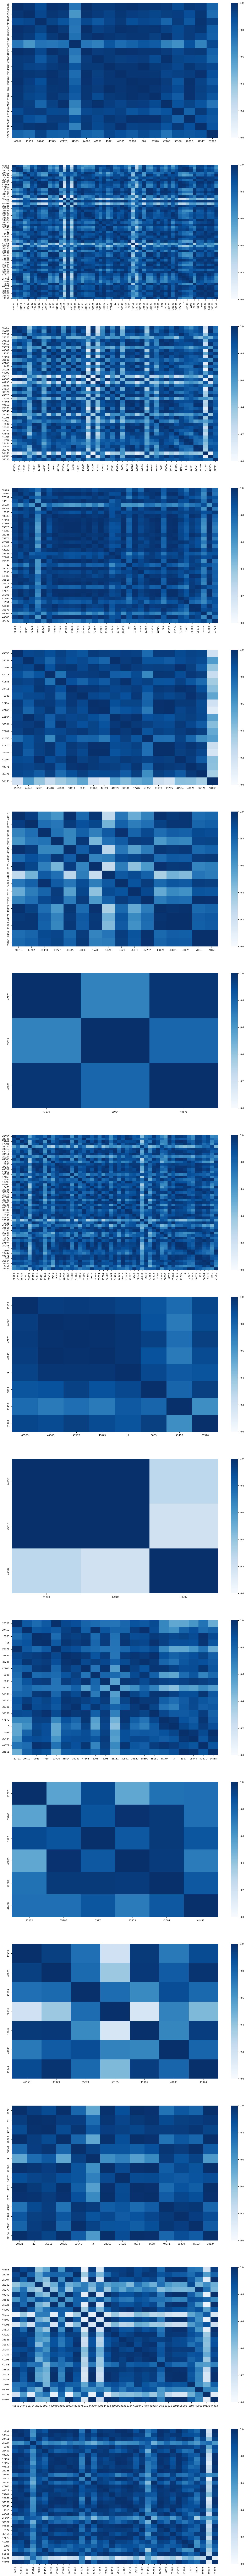

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_orig()
plt.clf()
figure, ax = plt.subplots(nrows = k_label, ncols =1 )
figure.set_size_inches(k_label,k_label*10)


for i in range(k_label):
    sns.heatmap(exploit_cosine_similarities[i], xticklabels= xyticklabels[i], yticklabels= xyticklabels[i], cmap='Blues', vmin=0, vmax=1, annot=False, ax = ax[i])
